In [128]:
import numpy as np
import numpy.typing as npt
from scipy.signal import correlate
import matplotlib.pyplot as plt
import sympy

In [129]:
for m in ["full", "same", "valid"]:
    print(correlate([1, 1, 1], [1, 1, 1], mode=m))

[1 2 3 2 1]
[2 3 2]
[3]


In [130]:
def _ura_mura(n):
    """
    From Yuri, generates a n * n ura/mura mask and its decoder. 
    """
    length = sympy.nextprime(n ** 2)
    ura = np.round(((length - 3) / 4.0) - ((length - 3) / 4.0)) == 0
    mura = np.round(((length - 1) / 4.0) - ((length - 1) / 4.0)) == 0
    if not ura and not mura:
        raise ValueError(f'length {n} not in URA/MURA sequences')

    a = np.zeros(length)
    r = (np.arange(0, length) ** 2) % length
    a[r] = 1
    g = a.copy()
    g[a == 0] = -1
    if mura:
        a[0], g[0] = 0, 1
    return tuple(map(lambda x: np.reshape(x[:n ** 2], (n, n)).astype(int), [a, g]))


In [131]:
class URA:
    def __init__(self, n: int):
        self.n = n
        self.shape = (n, n)
        self.mask, self.decoder = _ura_mura(self.n)
        self.open_fraction = np.sum(self.mask) / np.prod(self.shape)
        self._norm = 1 / np.sum(self.mask)

    def encode(self, sky: npt.NDArray) -> npt.NDArray:
        detector = correlate(self.mask, sky, mode="same") * self._norm
        return detector
    
    def decode(self, detector: npt.NDArray, balanced: bool | npt.NDArray = False) -> npt.NDArray:
        cc = correlate(self.decoder, detector, mode="full")
        if balanced is False:
            return cc
        elif balanced is True:
            bulk = np.ones(detector.shape)
        else:
            # we expect user to provide the sensitive array
            bulk = balanced
        return cc - correlate(self.decoder, bulk, mode="full") * np.sum(detector) / np.sum(bulk)

    def psf(self) -> npt.NDArray:
        return correlate(self.mask, self.decoder, mode="same")
    
    def get_sky_canvas(self) -> npt.NDArray:
        return np.zeros((2 * self.n, 2 * self.n))

In [132]:
ura = URA(37)

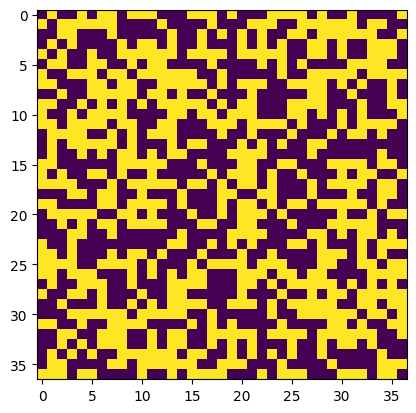

In [133]:
plt.imshow(ura.mask); plt.show()

In [134]:
sky = ura.get_sky_canvas()
for source in [(ura.n, ura.n, 1000)]:
    x, y, counts = source
    sky[x, y] = counts

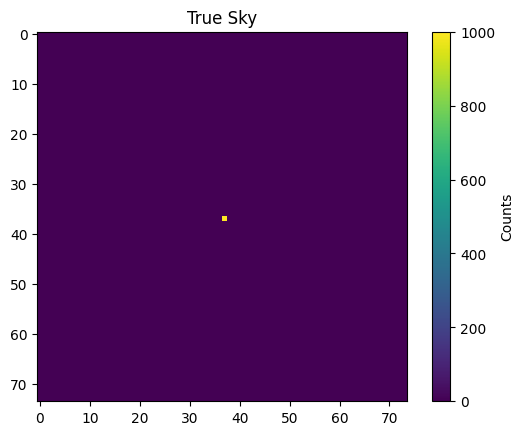

In [135]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(sky)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("True Sky")
plt.show()

In [136]:
detector = ura.encode(sky)

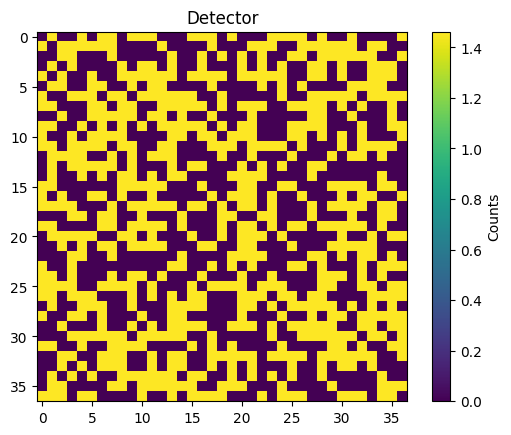

In [137]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

In [138]:
reconstructed = ura.decode(detector, balanced=False)
balanced = ura.decode(detector, balanced=True)

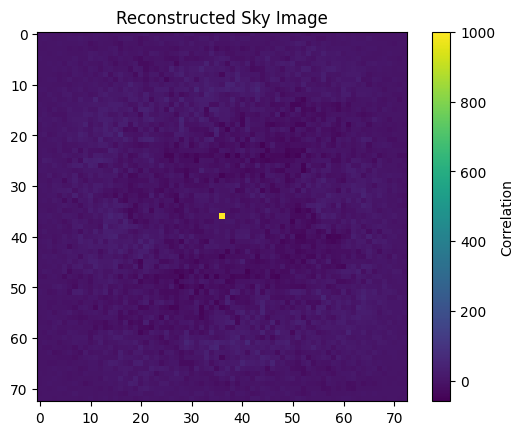

In [139]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstructed)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Reconstructed Sky Image")
plt.show()

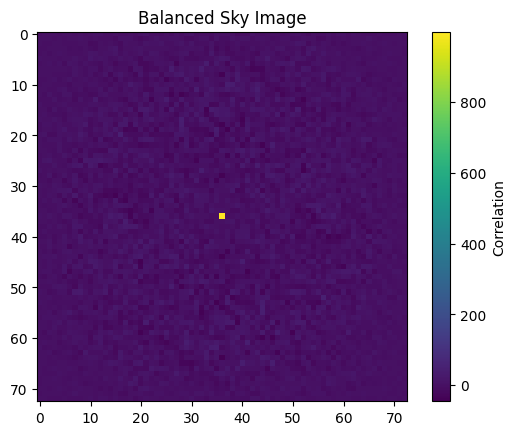

In [140]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Balanced Sky Image")
plt.show()

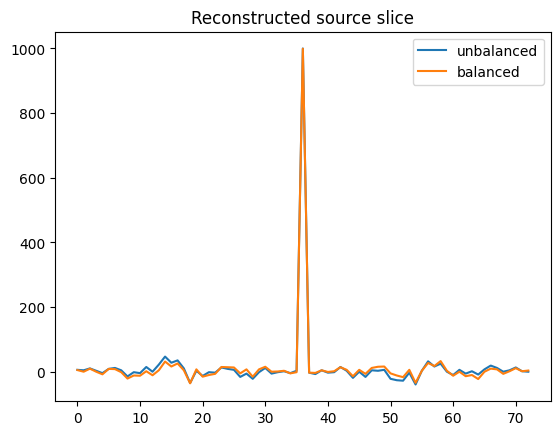

In [141]:
plt.plot(reconstructed[x - 1], label="unbalanced")
plt.plot(balanced[x - 1], label= "balanced")
plt.title("Reconstructed source slice")
plt.legend()
plt.show()

# Source and background

In [289]:
def simulate(fsources, b, mask, dsources = None):
    sky = mask.get_sky_canvas()
    n, m = sky.shape
    if dsources is None:
        dsources = np.dstack(
            [
                np.random.randint(n, size=len(fsources)),
                np.random.randint(m, size=len(fsources)),
            ]
        )[0]
        
    detector = np.zeros(mask.shape)
    transmitted = []
    for dsource, fsource in zip(dsources, fsources):
        _sky = mask.get_sky_canvas()
        _sky[*dsource] = fsource
        shadowed =np.isclose(mask.encode(_sky), np.zeros(mask.shape))
        counts = np.random.poisson(fsource / np.prod(mask.shape), size=mask.shape)
        counts[shadowed] = 0
        
        transmitted.append(np.sum(counts).item())
        detector += counts
        sky += _sky
    detector += np.random.poisson(b * mask.open_fraction, size=mask.mask.shape)
    sky += np.ones((n,m)) * b
    return detector, sky, {"source_directions": dsources, "source_transmitted": transmitted}

In [307]:
detector, sky, infos = simulate([10000, 5000, 5000,], 10, ura)
print(infos)

{'source_directions': array([[39, 20],
       [ 6, 54],
       [54, 33]]), 'source_transmitted': [2524, 222, 1161]}


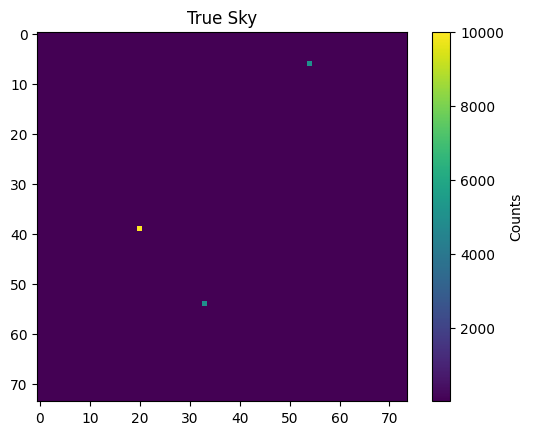

In [308]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(sky)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("True Sky")
plt.show()

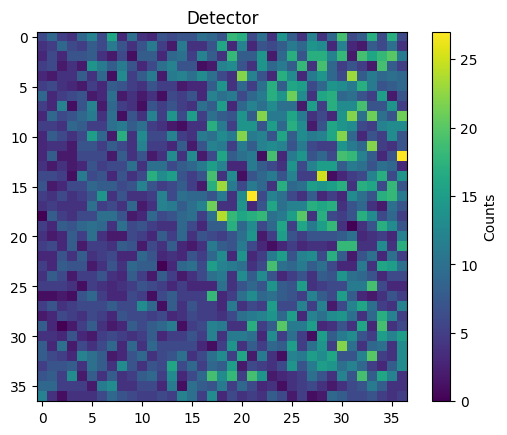

In [309]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

In [310]:
reconstructed = ura.decode(detector, balanced=False)
balanced = ura.decode(detector, balanced=True)

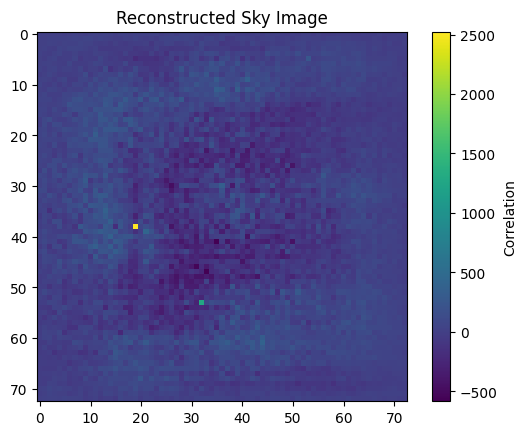

In [311]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstructed)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Reconstructed Sky Image")
plt.show()

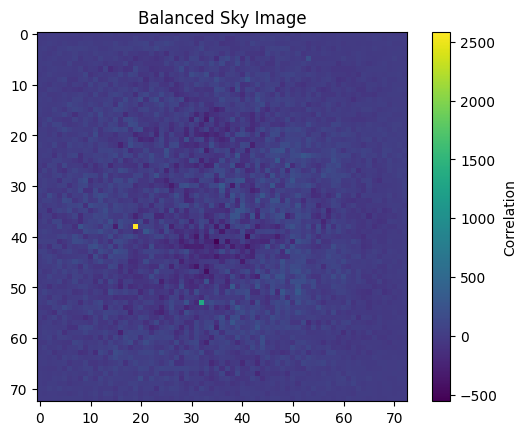

In [312]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Balanced Sky Image")
plt.show()

In [313]:
xs, ys = zip(*infos["source_directions"])

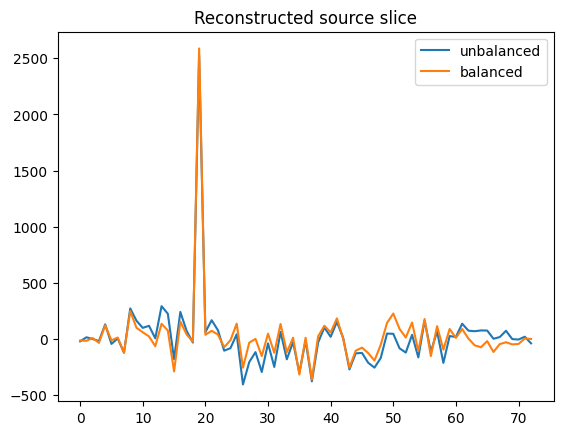

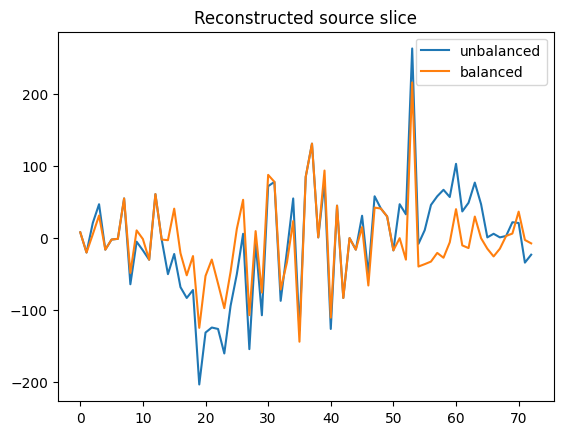

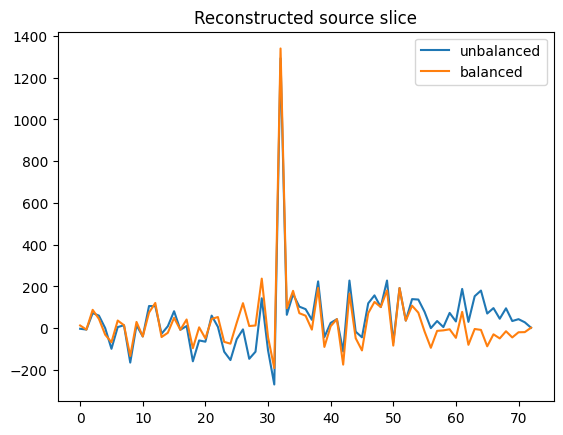

In [314]:
for x in xs:
    plt.show()
    plt.plot(reconstructed[x - 1], label="unbalanced")
    plt.plot(balanced[x - 1], label="balanced")
    plt.title("Reconstructed source slice")
    plt.legend()
    plt.show()